# 13 – Health Inequalities: Measuring the Gradient

**Learning Objectives:**
- Understand the Index of Multiple Deprivation (IMD) and how it is constructed
- Distinguish between life expectancy and healthy life expectancy
- Understand the distinction between absolute and relative measures of inequality
- Calculate the Slope Index of Inequality (SII) and Relative Index of Inequality (RII)
- Interpret concentration curves and concentration indices
- Apply these measures to dietary intake and nutrition-related health outcomes

---

## 1. Introduction: Why Measure Inequalities?

Average population health can improve while inequalities widen. Consider:

- Life expectancy in England increased for all groups between 2001-2019
- But the gap between the most and least deprived areas *also* increased

If we only track averages, we miss this divergence. Health inequality metrics help us:

1. **Describe** the current distribution of health across social groups
2. **Monitor** whether policies are reducing or widening gaps
3. **Target** interventions toward those in greatest need

### The Marmot Curve

Health follows a **gradient** — it's not simply that the poorest are unhealthy. Each step up the socioeconomic ladder is associated with better health outcomes.

## 2. Setup

In [60]:
# ============================================================
# Bootstrap cell (works both locally and in Colab)
# ============================================================

import os
import sys
import pathlib
import subprocess

REPO_URL = "https://github.com/ggkuhnle/fb2nep-epi.git"
REPO_DIR = "fb2nep-epi"

cwd = pathlib.Path.cwd()

if (cwd / "scripts" / "epi_utils.py").is_file():
    repo_root = cwd
elif (cwd.parent / "scripts" / "epi_utils.py").is_file():
    repo_root = cwd.parent
else:
    repo_root = cwd / REPO_DIR
    if not repo_root.is_dir():
        print(f"Cloning repository from {REPO_URL} ...")
        subprocess.run(["git", "clone", REPO_URL, str(repo_root)], check=True)
    else:
        print(f"Using existing repository at {repo_root}")
    os.chdir(repo_root)
    repo_root = pathlib.Path.cwd()

scripts_dir = repo_root / "scripts"
if str(scripts_dir) not in sys.path:
    sys.path.insert(0, str(scripts_dir))

print(f"Repository root: {repo_root}")
print("Bootstrap completed successfully.")

Repository root: /Users/gunter/Documents/fb2nep-epi
Bootstrap completed successfully.


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from ipywidgets import FloatSlider, VBox, Output
import ipywidgets as widgets
from IPython.display import display, HTML
from pathlib import Path
import openpyxl

from epi_utils import (
    calculate_sii, calculate_rii, calculate_concentration_index,
    plot_concentration_curve, INEQUALITY_EXAMPLE_DATA, fit_sii_rii
)

# ————— Paths —————
DATA_DIR = Path("../data")
IMD_CSV = DATA_DIR / "IoD2019_ranks.csv"
LE_CSV  = DATA_DIR / "le_imd.csv"
hse_path = DATA_DIR / "HSE-2022-Overweight-and-obesity-tables.xlsx"

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]
np.random.seed(42)

print("Libraries loaded successfully.")

Libraries loaded successfully.


## 3. The Index of Multiple Deprivation (IMD)

### What is the IMD?

The **Index of Multiple Deprivation (IMD)** is the official measure of relative deprivation for small areas in England. It ranks every **Lower Layer Super Output Area (LSOA)** — approximately 32,844 areas, each containing around 1,500 people.

### The Seven Domains of Deprivation

| Domain | Weight | What it measures |
|--------|--------|------------------|
| **Income** | 22.5% | Proportion of population on low income |
| **Employment** | 22.5% | Proportion involuntarily excluded from work |
| **Education** | 13.5% | Lack of attainment and skills |
| **Health & Disability** | 13.5% | Premature death and impairment |
| **Crime** | 9.3% | Risk of victimisation |
| **Barriers to Housing** | 9.3% | Physical and financial accessibility |
| **Living Environment** | 9.3% | Indoor and outdoor environment quality |

![IMD Domains](../_assets/imd_domains.png)

(https://assets.publishing.service.gov.uk/media/5d8e26f6ed915d5570c6cc55/IoD2019_Statistical_Release.pdf)

### Important Notes

1. **Relative, not absolute**: IMD ranks areas relative to each other
2. **Area-level, not individual**: Not everyone in a deprived area is deprived (ecological fallacy)
3. **England only**: Scotland, Wales, and Northern Ireland have separate indices

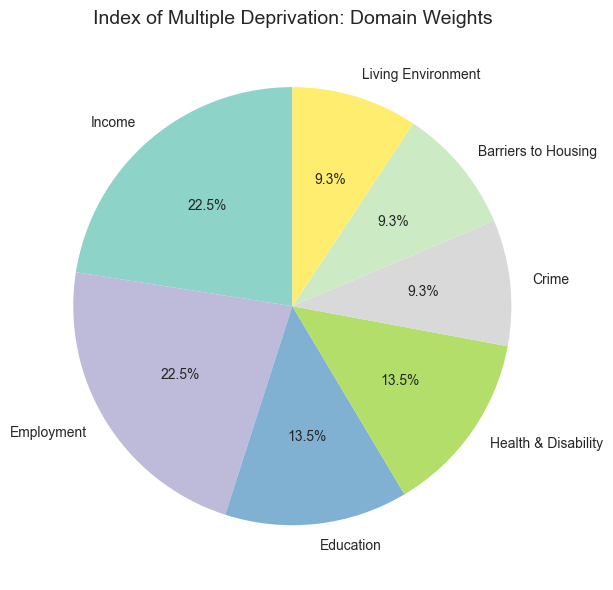

Note: Income and Employment together account for 45% of the overall IMD.


In [5]:
# IMD domain weights visualisation
imd_domains = pd.DataFrame({
    'Domain': ['Income', 'Employment', 'Education', 'Health & Disability', 
               'Crime', 'Barriers to Housing', 'Living Environment'],
    'Weight (%)': [22.5, 22.5, 13.5, 13.5, 9.3, 9.3, 9.3]
})

fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.Set3(np.linspace(0, 1, 7))
ax.pie(imd_domains['Weight (%)'], labels=imd_domains['Domain'],
       autopct='%1.1f%%', colors=colors, startangle=90)
ax.set_title('Index of Multiple Deprivation: Domain Weights', fontsize=14)
plt.tight_layout()
plt.show()

print("Note: Income and Employment together account for 45% of the overall IMD.")

### Exploring IMD Maps

**Key Resources:**

- [**ONS Interactive IMD Map**](https://dclgapps.communities.gov.uk/imd/iod_index.html) — Explore deprivation by LSOA
- [**CDRC IMD Geodata Pack**](https://data.cdrc.ac.uk/dataset/index-multiple-deprivation-imd) — Download IMD data
- [**PHE Fingertips**](https://fingertips.phe.org.uk/) — Health outcomes by deprivation

In [6]:
# Display link to interactive IMD map
display(HTML('''
<div style="text-align: center; padding: 20px; background-color: #f5f5f5; border-radius: 10px;">
    <h3>Index of Multiple Deprivation 2019 - England</h3>
    <p><a href="https://dclgapps.communities.gov.uk/imd/iod_index.html" target="_blank">
        Click here to explore the interactive IMD map →
    </a></p>
    <p style="font-size: 12px; color: #666;">Source: MHCLG (2019)</p>
</div>
'''))

In [19]:

# ————— Load the full CSV —————
df = pd.read_csv(IMD_CSV)

# ————— Extract LA-level summary —————
# Select only the columns we need
df_la = (
    df[[
        "Local Authority District name (2019)",
        "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)",
        "Index of Multiple Deprivation (IMD) Score"
    ]]
    .dropna()
    # Rename for convenience
    .rename(columns={
        "Local Authority District name (2019)": "Local Authority",
        "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)": "IMD Rank",
        "Index of Multiple Deprivation (IMD) Score": "IMD Score"
    })
    .drop_duplicates()
    # Sort so rank=1 is top
    .sort_values("IMD Rank")
    .reset_index(drop=True)
)

print("Loaded IMD 2019 LA ranks:")

# 
# Most and least deprived local authorities
la_deprivation = pd.DataFrame({
    'Local Authority': ['Blackpool', 'Knowsley', 'Hull', 'Middlesbrough', 'Liverpool',
                        'Hart', 'Wokingham', 'Surrey Heath', 'S. Cambridgeshire', 'Elmbridge'],
    'Rank (of 317)': [1, 2, 3, 4, 5, 317, 316, 315, 314, 313],
    'Category': ['Most deprived'] * 5 + ['Least deprived'] * 5
})

print("Most and Least Deprived Local Authorities (IMD 2019)")
print("=" * 60)
display(la_deprivation)

Loaded IMD 2019 LA ranks:
Most and Least Deprived Local Authorities (IMD 2019)


,Local Authority,Rank (of 317),Category
0,Blackpool,1,Most deprived
1,Knowsley,2,Most deprived
2,Hull,3,Most deprived
3,Middlesbrough,4,Most deprived
4,Liverpool,5,Most deprived
5,Hart,317,Least deprived
6,Wokingham,316,Least deprived
7,Surrey Heath,315,Least deprived
8,S. Cambridgeshire,314,Least deprived
9,Elmbridge,313,Least deprived


Most local authorities cluster across the distribution; only a few lie at the extremes. So where are we?

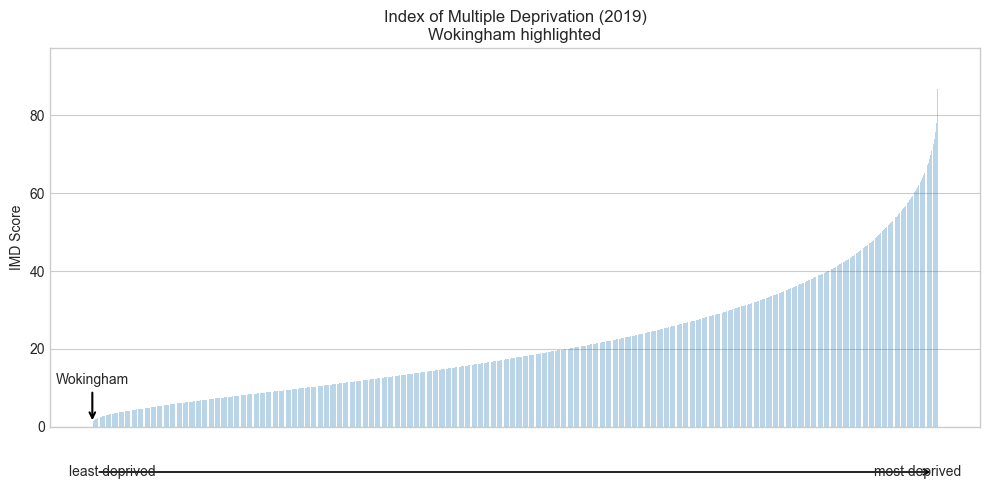

In [24]:
df_plot = df_la.sort_values("IMD Score").reset_index(drop=True)



# Boolean mask for Wokingham
is_wokingham = df_plot["Local Authority"] == "Wokingham"

# Locate Wokingham
wk_idx = df_plot.index[df_plot["Local Authority"] == "Wokingham"][0]
wk_score = df_plot.loc[wk_idx, "IMD Score"]

# X positions (one per authority)
x = np.arange(len(df_plot))

plt.figure(figsize=(10, 5))

# All authorities (background)
plt.bar(
    x,
    df_plot["IMD Score"],
    alpha=0.3
)

# Arrow pointing to Wokingham
plt.annotate(
    "Wokingham",
    xy=(wk_idx, wk_score),
    xytext=(wk_idx, wk_score + 10),  # vertical offset
    arrowprops=dict(
        arrowstyle="->",
        linewidth=1.5
    ),
    ha="center"
)

plt.annotate(
    "",
    xy=(0.95, -0.12),
    xytext=(0.05, -0.12),
    xycoords="axes fraction",
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="->", linewidth=1.2),
)

# End labels
plt.text(
    0.02, -0.12, "least deprived",
    transform=plt.gca().transAxes,
    ha="left", va="center"
)

plt.text(
    0.98, -0.12, "most deprived",
    transform=plt.gca().transAxes,
    ha="right", va="center"
)

# Axis handling
plt.xticks([])  # remove unreadable labels
plt.ylabel("IMD Score")
plt.title("Index of Multiple Deprivation (2019)\nWokingham highlighted")

plt.tight_layout()
plt.show()

## 4. Life Expectancy vs Healthy Life Expectancy

### Definitions

- **Life expectancy (LE)**: Average years a newborn would live if current mortality rates persist
- **Healthy life expectancy (HLE)**: Average years expected in "good" or "very good" health

### The Double Burden of Deprivation

The gap between LE and HLE represents **years lived in poor health**. In deprived areas, people:
1. Die younger
2. Spend a larger proportion of their shorter lives in poor health

In [42]:
le_hle_data = pd.read_csv(LE_CSV)


# Sort in the natural order (most deprived -> least deprived)
le_hle_data = le_hle_data.sort_values("IMD_decile").reset_index(drop=True)

print("Life Expectancy and Healthy Life Expectancy by IMD Decile (England, 2020–2022)")
display(le_hle_data[["IMD_decile", "LE_male", "HLE_male", "LE_female", "HLE_female"]])

Life Expectancy and Healthy Life Expectancy by IMD Decile (England, 2020–2022)


,IMD_decile,LE_male,HLE_male,LE_female,HLE_female
0,1,72.58,51.13,77.66,50.54
1,2,74.92,55.64,79.58,55.01
2,3,76.56,58.79,81.01,59.28
3,4,77.94,60.09,82.09,61.26
4,5,79.09,62.61,83.00,63.05
5,6,80.06,64.20,83.65,64.38
6,7,80.64,65.17,84.17,66.37
7,8,81.36,66.77,84.63,68.01
8,9,81.93,68.26,85.18,68.70
9,10,82.98,70.09,86.08,70.16


The State Pension Age is 66 (rising to 67 by 2028). In the most deprived areas, men reach their HLE **14.5 years BEFORE** pension age.

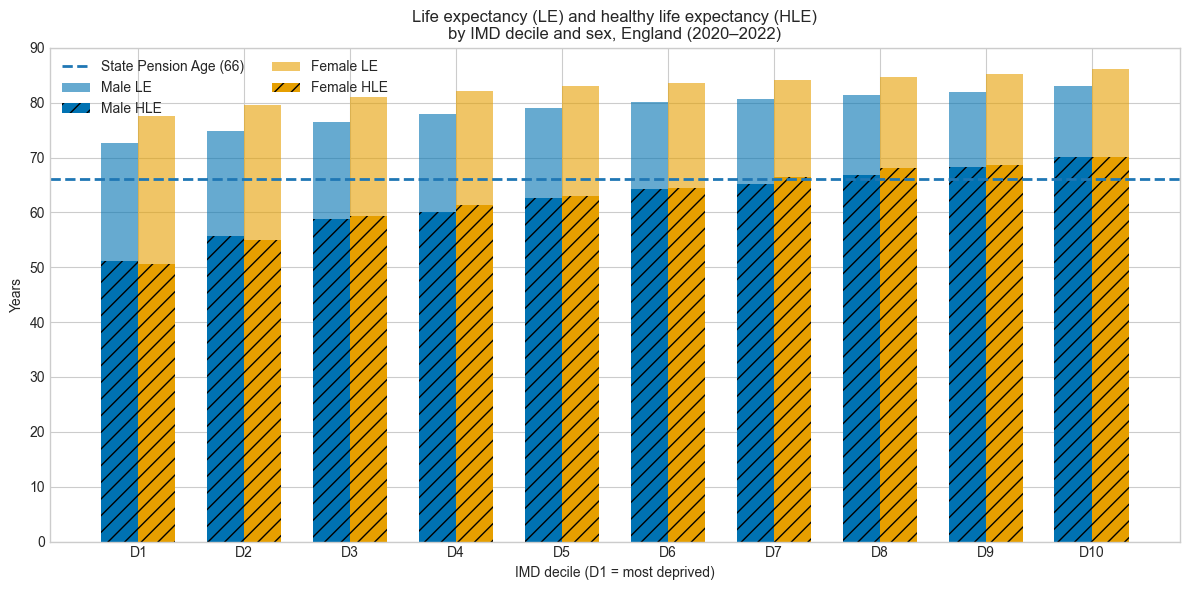

In [51]:
pension_age = 66

# X positions
x = np.arange(len(le_hle_data))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

# Colour-blind safe palette (Okabe–Ito)
male_colour = "#0072B2"    # blue
female_colour = "#E69F00"  # orange

# ---- Male bars ----
ax.bar(
    x - width/2,
    le_hle_data["LE_male"],
    width,
    label="Male LE",
    color=male_colour,
    alpha=0.6,
    hatch=""
)
ax.bar(
    x - width/2,
    le_hle_data["HLE_male"],
    width,
    label="Male HLE",
    color=male_colour,
    hatch="//"
)

# ---- Female bars ----
ax.bar(
    x + width/2,
    le_hle_data["LE_female"],
    width,
    label="Female LE",
    color=female_colour,
    alpha=0.6,
    hatch=""
)
ax.bar(
    x + width/2,
    le_hle_data["HLE_female"],
    width,
    label="Female HLE",
    color=female_colour,
    hatch="//"
)

# ---- Axes and labels ----
ax.set_xticks(x)
ax.set_xticklabels([f"D{d}" for d in le_hle_data["IMD_decile"]])
ax.set_xlabel("IMD decile (D1 = most deprived)")
ax.set_ylabel("Years")
ax.set_title(
    "Life expectancy (LE) and healthy life expectancy (HLE)\n"
    "by IMD decile and sex, England (2020–2022)"
)
ax.set_ylim(0, 90)

# ---- Pension age line ----
ax.axhline(
    y=pension_age,
    linestyle="--",
    linewidth=2,
    label=f"State Pension Age ({pension_age})"
)

# ---- Legend ----
ax.legend(ncol=2, loc="upper left")



plt.tight_layout()
plt.show()


## 5. Measuring Inequality: SII and RII

When comparing **D1 vs D10**, only two points on the deprivation gradient are used.  
This is simple, but it discards information and is sensitive to noise at the extremes.

The **Slope Index of Inequality (SII)** and **Relative Index of Inequality (RII)** were designed to do something more principled:

- use **all groups** (all deciles, quintiles, etc.)
- account for **group population size** (if groups are unequal)
- summarise the **entire social gradient** with a single number
- allow comparison across places and time

They are widely used in health inequalities research for precisely these reasons.




## Slope Index of Inequality (SII)

### What SII measures

**SII is an absolute measure of inequality.**  
It estimates the **absolute difference** in the outcome between the theoretical extremes of the deprivation distribution:

> predicted outcome at the least deprived end minus predicted outcome at the most deprived end

If the outcome is **healthy life expectancy (HLE)**, SII is measured in **years**.

Example interpretation:

> An SII of 18 years for HLE means that, across the deprivation gradient, the fitted difference between the least and most deprived ends is about 18 healthy years.

### Why “theoretical” extremes?

SII does not simply compare observed values in D1 and D10.  
Instead, it models deprivation as a **continuous gradient** from 0 to 1 and estimates outcomes at those endpoints.

This makes SII more stable than a simple top–bottom gap.

---

## From categories to a gradient: the ridit score

Deprivation is observed in categories (deciles), but inequality is a **gradient concept**.

### Step 1: cumulative population position

Assuming equal-sized deciles:

- Decile 1 spans ranks 0.0–0.1  
- Decile 2 spans 0.1–0.2  
- …  
- Decile 10 spans 0.9–1.0  

### Step 2: midpoint (ridit)

Each group is assigned the midpoint of its interval:

| Decile | Ridit |
|------|-------|
| D1 | 0.05 |
| D2 | 0.15 |
| … | … |
| D10 | 0.95 |

These ridit values represent **relative social position** and become the x-values in the regression.

If groups differ in population size, midpoints are computed from the cumulative population distribution instead. This is one reason SII is preferred over simple gaps.

---

## Regression formulation

The outcome y (e.g. HLE) is regressed on the ridit r:

y = α + βr

- r ∈ [0, 1]
- α: predicted outcome at the most deprived end
- α + β: predicted outcome at the least deprived end

Therefore:

SII = (α + β) − α = β

In a linear model, **SII is simply the slope**, provided the rank variable runs from 0 to 1.

### Interpretation

- **Positive SII**: outcome increases with decreasing deprivation (typical for favourable health outcomes)
- **Negative SII**: outcome higher in more deprived groups

Because SII is absolute, it uses the **units of the outcome**:
- years (LE, HLE)
- mmHg (blood pressure)
- percentage points (prevalence)

---

## Why using all points matters

Using all groups rather than only extremes provides:

### 1. Greater stability
Extreme groups can be noisy. A fitted gradient uses all observations.

### 2. Representativeness
SII summarises the entire gradient, not just its endpoints.

### 3. Population weighting
If group sizes differ, SII can reflect the distribution of people rather than categories.

---

## Assumptions behind SII

1. **Approximate linearity**  
   SII is a linear summary. If the gradient is curved, SII still exists but compresses that pattern into a single number.

2. **Meaningful ordering**  
   Deprivation categories must be ordinal (IMD satisfies this).

3. **Appropriate outcome model**  
   - Continuous outcomes: linear regression  
   - Rates or proportions: suitable GLMs may be preferable

SII answers:

> “What is the best linear summary of inequality across the social gradient?”



In [58]:
# Read the table "as is" (HSE tables are not tidy spreadsheets)
t6 = pd.read_excel(hse_path, sheet_name="Table 6", header=None)

# Quintile labels are on row 3, columns 1..5 in this workbook
quintile_labels = list(t6.iloc[3, 1:6].values)

# Helper: find a row by exact label in column 0
def _row_idx(label: str) -> int:
    matches = t6.index[t6[0].astype(str).str.strip().eq(label)]
    if len(matches) == 0:
        raise ValueError(f"Could not find row label: {label!r}")
    return int(matches[0])

# Row indices for obesity prevalence (% Obese) for each sex
row_male_obese = _row_idx("% Obese")          # first occurrence is in the Men section
row_women = _row_idx("Women")                 # marker row; women section starts here
row_female_obese = t6.index[(t6.index > row_women) & (t6[0].astype(str).str.strip().eq("% Obese"))][0]

# Row indices for weighted bases (Men and Women)
row_weighted_bases = _row_idx("Weighted bases")
row_male_weight = row_weighted_bases + 1      # Men
row_female_weight = row_weighted_bases + 2    # Women

# Extract values (columns 1..5 correspond to quintiles)
male_prev_pct = t6.iloc[row_male_obese, 1:6].astype(float).values
female_prev_pct = t6.iloc[row_female_obese, 1:6].astype(float).values

male_weight = t6.iloc[row_male_weight, 1:6].astype(float).values
female_weight = t6.iloc[row_female_weight, 1:6].astype(float).values

# Build tidy dataframe (convert % to proportions)
df = pd.DataFrame({
    "quintile_label": quintile_labels * 2,
    "sex": ["Men"] * 5 + ["Women"] * 5,
    "obesity_prev": np.concatenate([male_prev_pct, female_prev_pct]) / 100.0,
    "weighted_base": np.concatenate([male_weight, female_weight]),
})

# Reorder so that ridit = 0 is MOST deprived and ridit = 1 is LEAST deprived.
# In this table the columns run Least -> Most, so reverse within each sex.
def _reorder_most_to_least(group: pd.DataFrame) -> pd.DataFrame:
    return group.iloc[::-1].reset_index(drop=True)

df = df.groupby("sex", group_keys=False).apply(_reorder_most_to_least)

# Compute population share within sex (weights sum to 1 within each sex)
df["population_share"] = df["weighted_base"] / df.groupby("sex")["weighted_base"].transform("sum")

# Compute ridit using the cumulative population distribution (weighted)
df["cum_pop"] = df.groupby("sex")["population_share"].cumsum()
df["cum_pop_lag"] = df.groupby("sex")["cum_pop"].shift(1, fill_value=0)
df["ridit"] = (df["cum_pop"] + df["cum_pop_lag"]) / 2

display(df)

<positron-console-cell-58>:44: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,quintile_label,sex,obesity_prev,weighted_base,population_share,cum_pop,cum_pop_lag,ridit
0,Most deprived,Men,0.314756,382.009909,0.169367,0.169367,0.000000,0.084683
1,4th,Men,0.285117,388.706323,0.172335,0.341702,0.169367,0.255534
2,3rd,Men,0.286702,494.083242,0.219055,0.560757,0.341702,0.451230
3,2nd,Men,0.309119,482.500349,0.213920,0.774677,0.560757,0.667717
4,Least deprived,Men,0.214067,508.221417,0.225323,1.000000,0.774677,0.887338
0,Most deprived,Women,0.399636,385.382270,0.168531,0.168531,0.000000,0.084265
1,4th,Women,0.333164,421.332809,0.184252,0.352783,0.168531,0.260657
2,3rd,Women,0.299719,468.725391,0.204978,0.557761,0.352783,0.455272
3,2nd,Women,0.253617,486.702859,0.212839,0.770600,0.557761,0.664181
4,Least deprived,Women,0.226968,524.571498,0.229400,1.000000,0.770600,0.885300


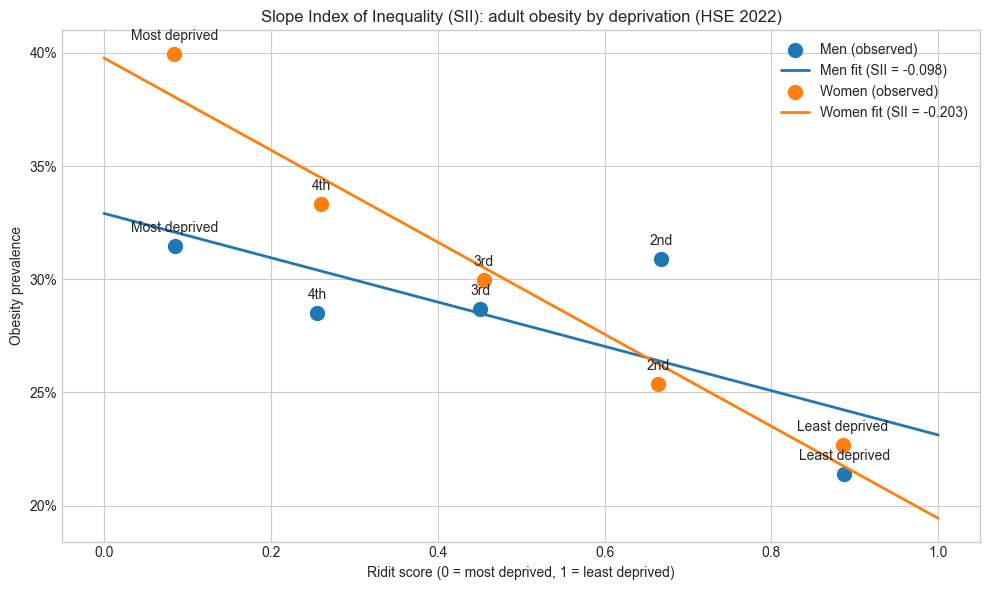

Men: SII = -0.098 (absolute change in prevalence from most to least deprived)
Women: SII = -0.203 (absolute change in prevalence from most to least deprived)


In [62]:
fig, ax = plt.subplots(figsize=(10, 6))

x_line = np.linspace(0, 1, 200)

for sex, res in results.items():
    g = res["data"]

    ax.scatter(g["ridit"], g["obesity_prev"], s=100, label=f"{sex} (observed)")
    ax.plot(x_line, res["sii_intercept"] + res["sii"] * x_line,
            linewidth=2, label=f"{sex} fit (SII = {res['sii']:.3f})")

    for _, row in g.iterrows():
        ax.annotate(row["quintile_label"], (row["ridit"], row["obesity_prev"]),
                    textcoords="offset points", xytext=(0, 10), ha="center")

ax.set_xlabel("Ridit score (0 = most deprived, 1 = least deprived)")
ax.set_ylabel("Obesity prevalence")
ax.set_title("Slope Index of Inequality (SII): adult obesity by deprivation (HSE 2022)")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
ax.legend()
plt.tight_layout()
plt.show()

for sex, res in results.items():
    print(f"{sex}: SII = {res['sii']:.3f} (absolute change in prevalence from most to least deprived)")


## Relative Index of Inequality (RII)

**RII is the relative counterpart of SII.**  
Instead of an absolute difference, it expresses inequality as a **ratio**.

A common formulation:

log(y) = α + βr

Then:

RII = exp(β)

Interpretation:
- RII = 1.25 → outcome is about **25% higher** at the least deprived end than at the most deprived end (in the fitted gradient)

RII is often preferred for:
- prevalence
- rates
- outcomes naturally interpreted multiplicatively


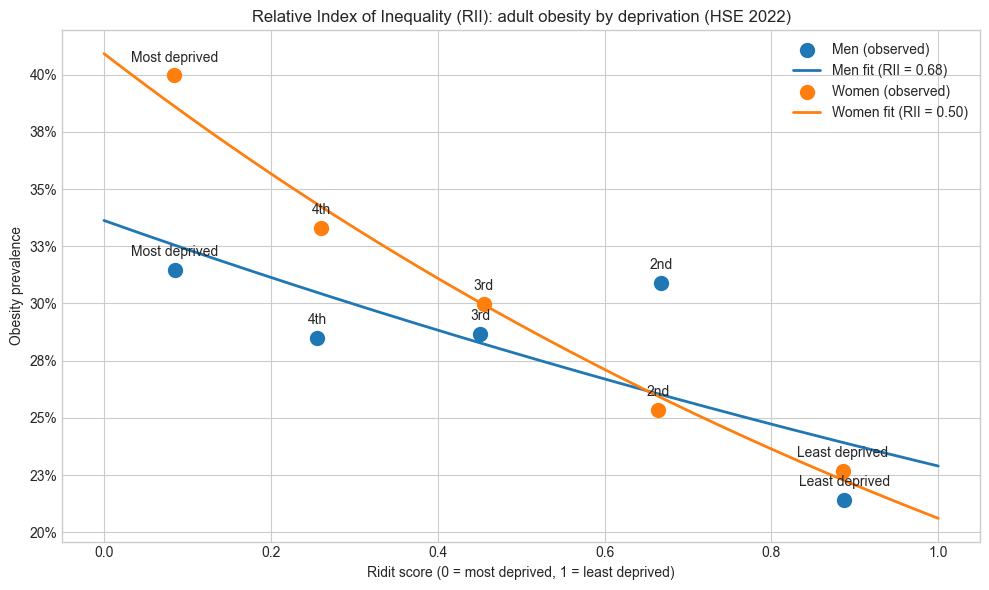

Men: RII = 0.68 (ratio across the gradient, least vs most deprived in fitted model)
Women: RII = 0.50 (ratio across the gradient, least vs most deprived in fitted model)


In [63]:
fig, ax = plt.subplots(figsize=(10, 6))

for sex, res in results.items():
    g = res["data"]

    ax.scatter(g["ridit"], g["obesity_prev"], s=100, label=f"{sex} (observed)")
    ax.plot(x_line, np.exp(res["rii_intercept"] + res["rii_slope"] * x_line),
            linewidth=2, label=f"{sex} fit (RII = {res['rii']:.2f})")

    for _, row in g.iterrows():
        ax.annotate(row["quintile_label"], (row["ridit"], row["obesity_prev"]),
                    textcoords="offset points", xytext=(0, 10), ha="center")

ax.set_xlabel("Ridit score (0 = most deprived, 1 = least deprived)")
ax.set_ylabel("Obesity prevalence")
ax.set_title("Relative Index of Inequality (RII): adult obesity by deprivation (HSE 2022)")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
ax.legend()
plt.tight_layout()
plt.show()

for sex, res in results.items():
    print(f"{sex}: RII = {res['rii']:.2f} (ratio across the gradient, least vs most deprived in fitted model)")


## Summary 

> We replace deprivation categories by their position in the cumulative population distribution (ridit). We then regress the outcome on this rank. The slope of that regression gives the SII: the predicted absolute difference between the least and most deprived ends of society, using all groups rather than only the extremes.

## 6. Discussion Questions

1. **IMD limitations**: Why might the IMD be a poor measure of individual deprivation?

2. **LE vs HLE**: Why is the HLE gap larger than the LE gap? What does this imply for pension policy?

3. **Proportionate universalism**: How might you measure whether a dietary intervention follows this principle?

## 7. Exercises

### Exercise 1: Explore IMD in Your Area

1. Go to the [ONS IMD Explorer](https://dclgapps.communities.gov.uk/imd/iod_index.html)
2. Find your home area (or Reading)
3. Note the IMD decile and domain scores

In [ ]:
# Record your findings
my_area = {
    'Area name': '',
    'IMD Decile': None,
    'Most deprived domain': ''
}

---

## Summary

- **IMD** combines seven domains to rank areas by deprivation
- **Healthy life expectancy** reveals larger inequality gaps than total LE
- The "double burden" means deprived populations live shorter lives AND more years in poor health
- **SII** measures absolute inequality; **RII** expresses it relatively

## Key Resources

- [ONS IMD Interactive Map](https://dclgapps.communities.gov.uk/imd/iod_index.html)
- [PHE Fingertips](https://fingertips.phe.org.uk/)
- [ONS Health State Life Expectancy](https://www.ons.gov.uk/peoplepopulationandcommunity/healthandsocialcare/healthandlifeexpectancies)

## References

- MHCLG (2019). English Indices of Deprivation.
- Marmot M (2010). Fair Society, Healthy Lives.
- Marmot M (2020). Health Equity in England: The Marmot Review 10 Years On.